# Regression with Different Optimizers

In [6]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print(f"matplotlib version:[{matplotlib.__version__}].")
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

matplotlib version:[3.3.4].
PyTorch version:[1.10.1].
device:[cpu].


### Dataset

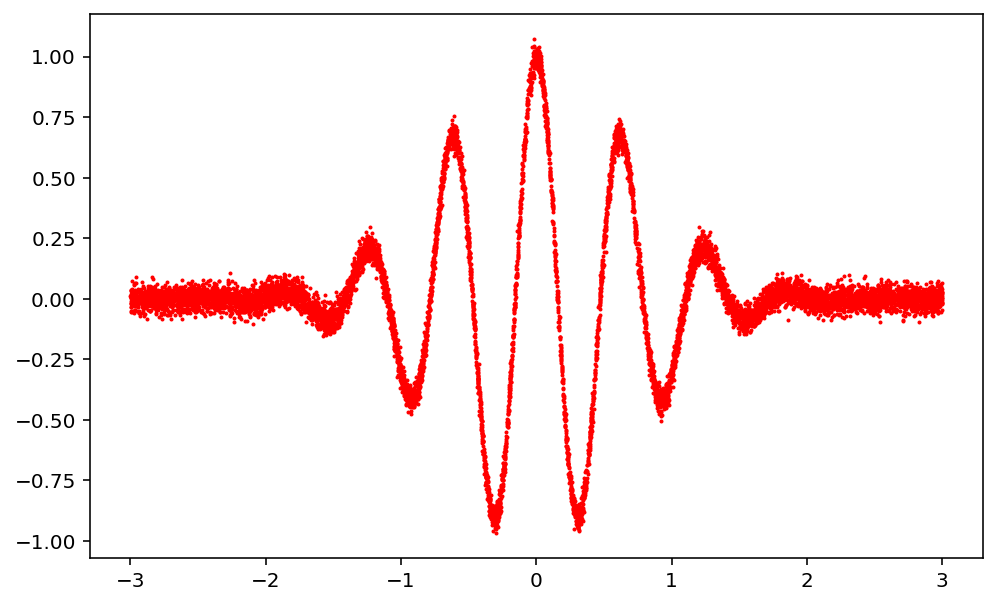

Done.


In [7]:
n_data = 10000
x_numpy = -3+6*np.random.rand(n_data,1)
y_numpy = np.exp(-(x_numpy**2))*np.cos(10*x_numpy) + 3e-2*np.random.randn(n_data,1)
plt.figure(figsize=(8,5))
plt.plot(x_numpy,y_numpy,'r.',ms=2)
plt.show()
x_torch = torch.Tensor(x_numpy).to(device)
y_torch = torch.Tensor(y_numpy).to(device)
print ("Done.")

### Define Model

In [8]:
class Model(nn.Module):
    def __init__(self,name='mlp',xdim=1,hdims=[16,16],ydim=1):
        super(Model, self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdims = hdims
        self.ydim = ydim

        self.layers = []
        prev_hdim = self.xdim
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim, hdim, bias=True))
            self.layers.append(nn.Tanh())  # activation
            prev_hdim = hdim
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

        # Concatenate all layers 
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer)

        self.init_param() # initialize parameters
    
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self,x):
        return self.net(x)

print ("Done.")        

Done.


In [9]:
eta = 1e-2
# Instantiate models
model_sgd = Model(name='mlp_sgd',xdim=1,hdims=[64,64],ydim=1).to(device)
model_momentum = Model(name='mlp_momentum',xdim=1,hdims=[64,64],ydim=1).to(device)
model_adam = Model(name='mlp_adam',xdim=1,hdims=[64,64],ydim=1).to(device)
# Optimizers
loss = nn.MSELoss()
optm_sgd = optim.SGD(model_sgd.parameters(), lr = eta)
optm_momentum = optim.SGD(model_momentum.parameters(), lr=eta, momentum=0.9)
optm_adam = optim.Adam(model_adam.parameters(), lr=eta)
print ("Done.")

Done.


### Check Parameters

In [10]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(model_sgd.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.linear_00.weight] shape:[(64, 1)].
    val:[-0.409 -0.042  1.015  1.494  1.02 ]
[1] name:[net.linear_00.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.linear_02.weight] shape:[(64, 64)].
    val:[-0.06   0.104  0.107 -0.027  0.277]
[3] name:[net.linear_02.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_04.weight] shape:[(1, 64)].
    val:[ 0.189  0.23  -0.41   0.071 -0.053]
[5] name:[net.linear_04.bias] shape:[(1,)].
    val:[0.]
Total number of parameters:[4,353].


### Train

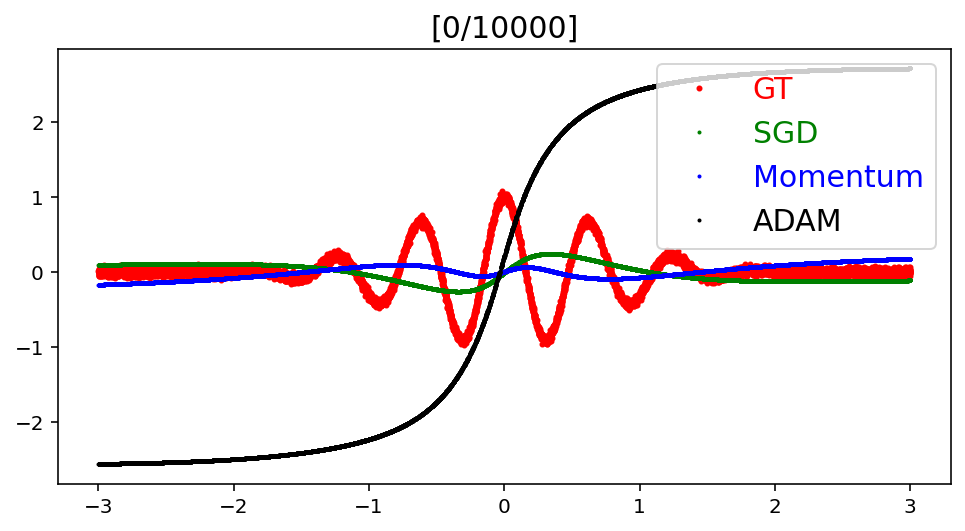

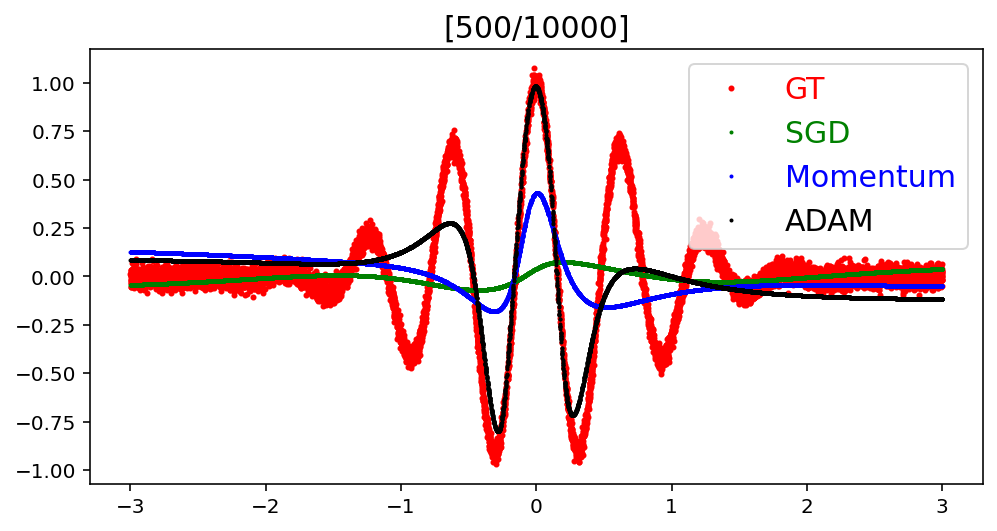

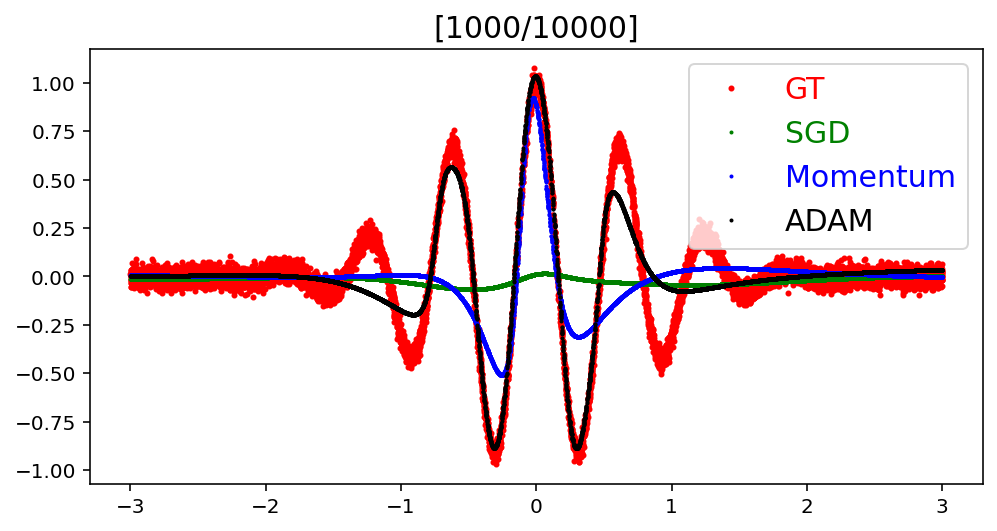

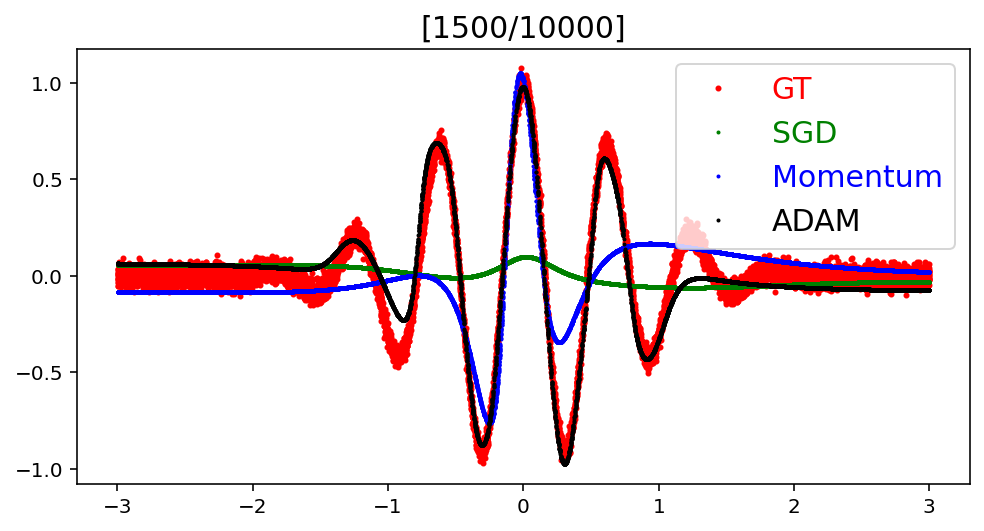

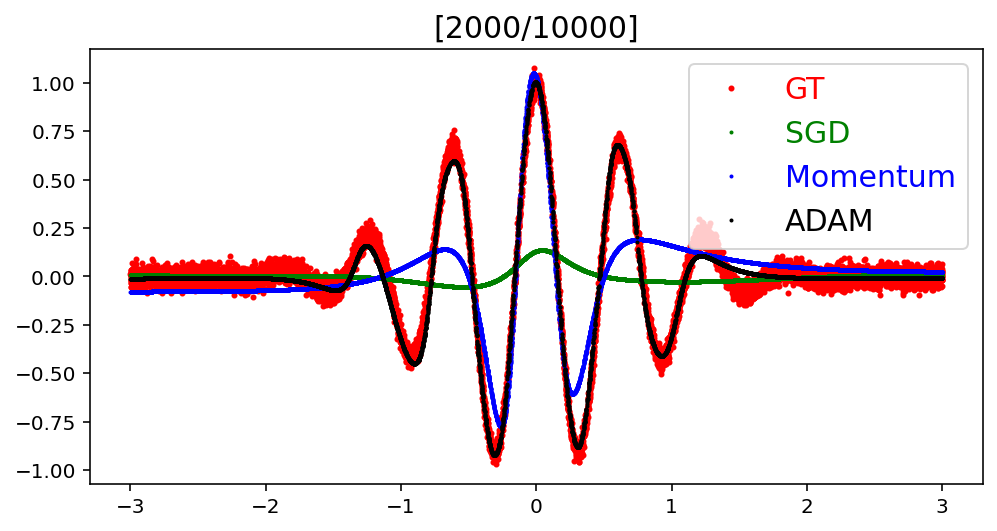

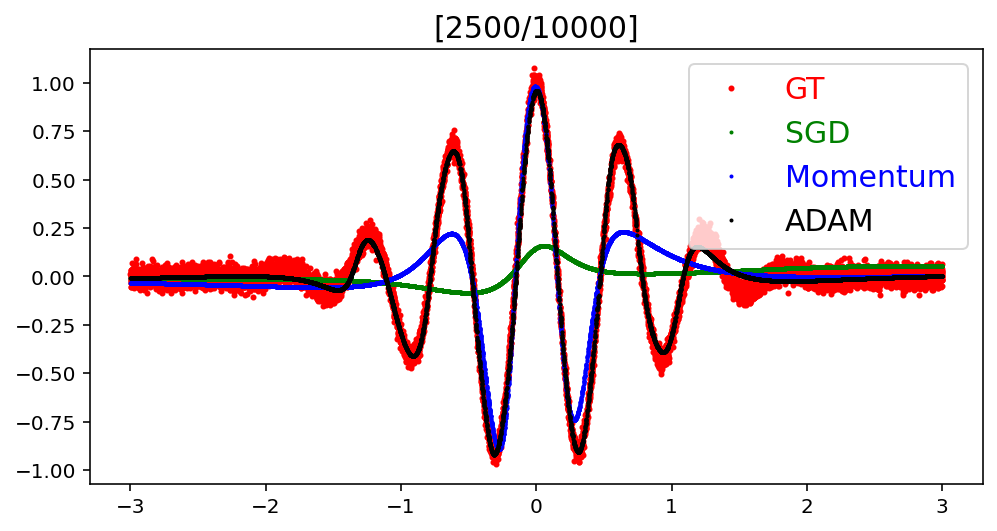

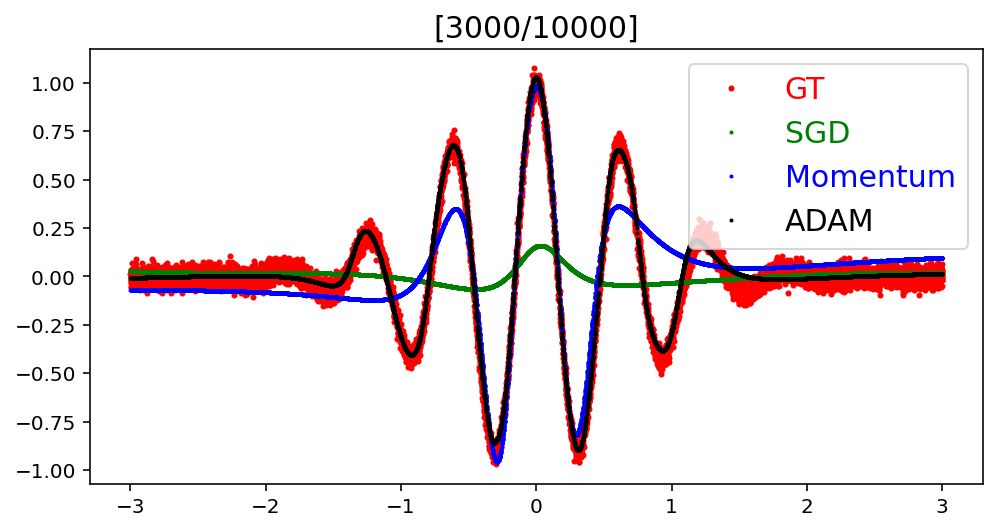

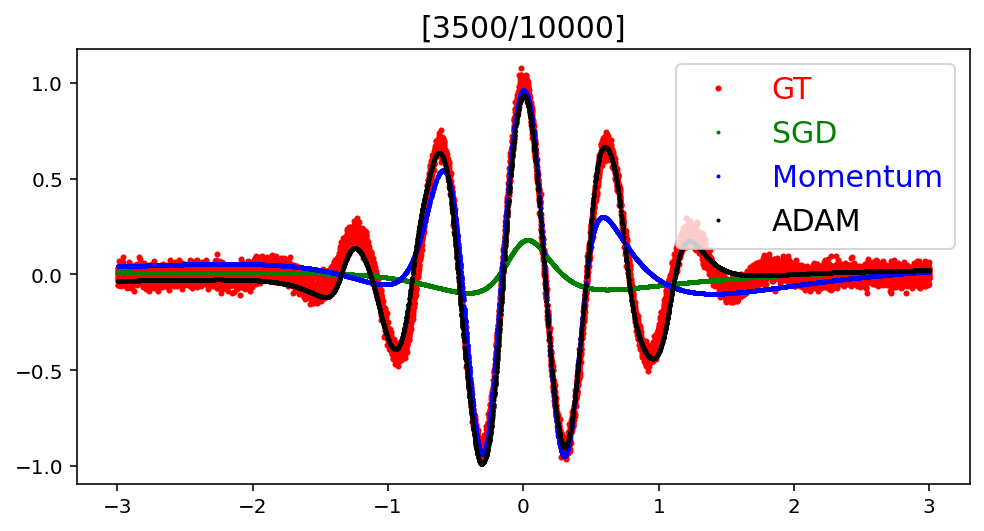

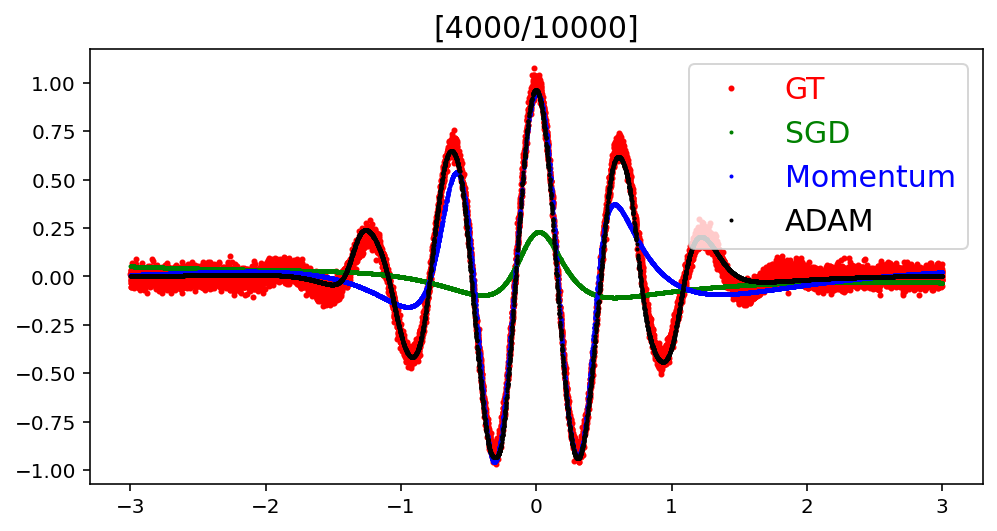

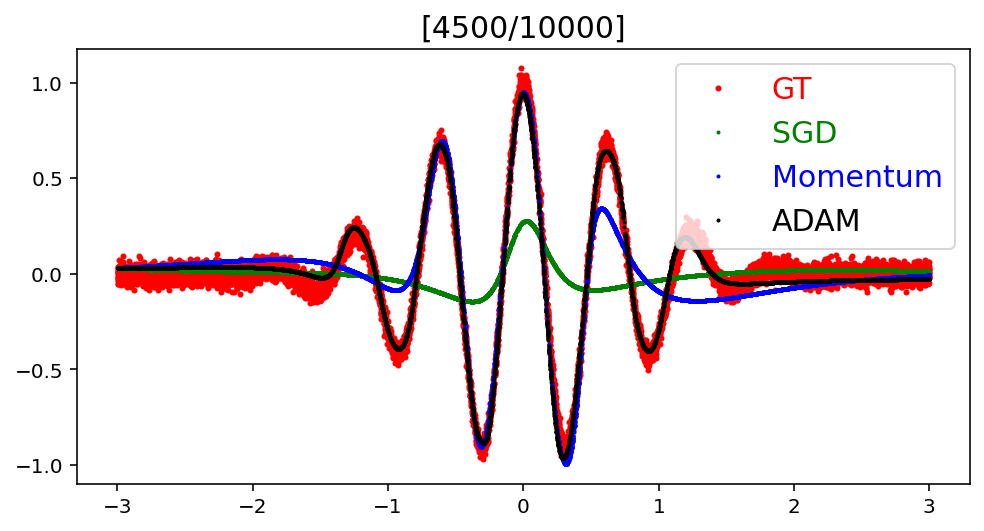

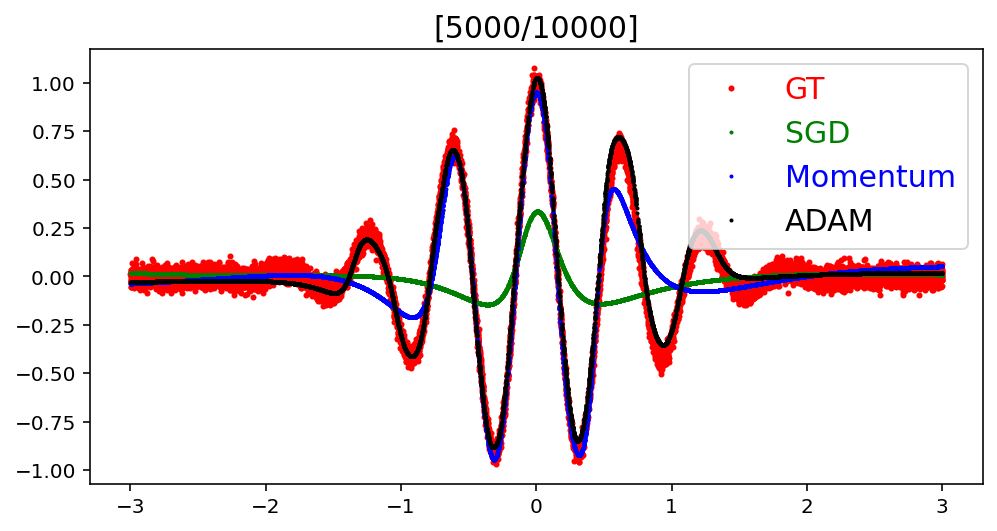

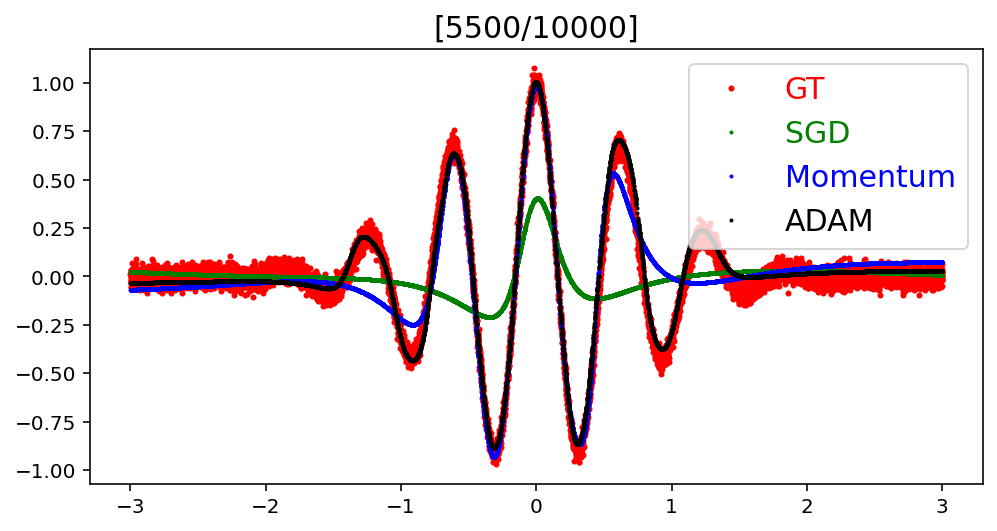

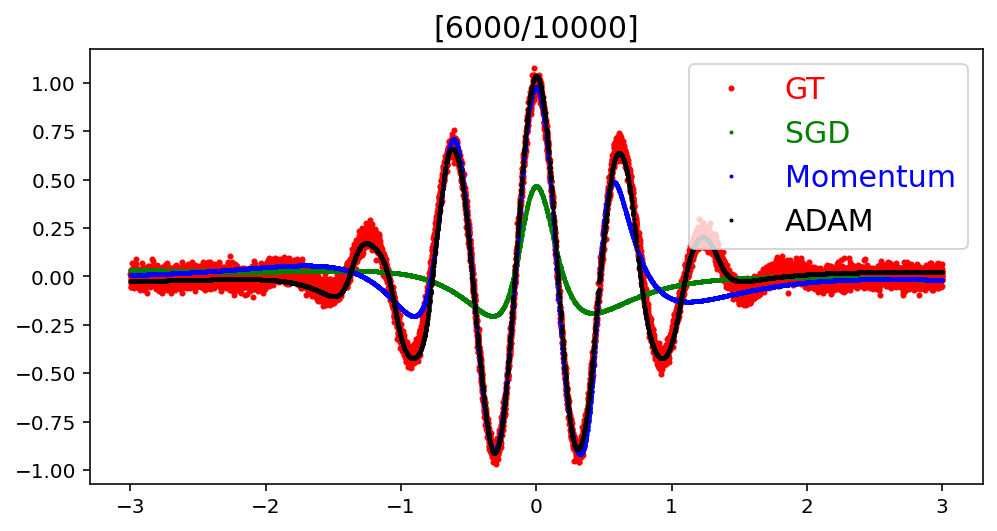

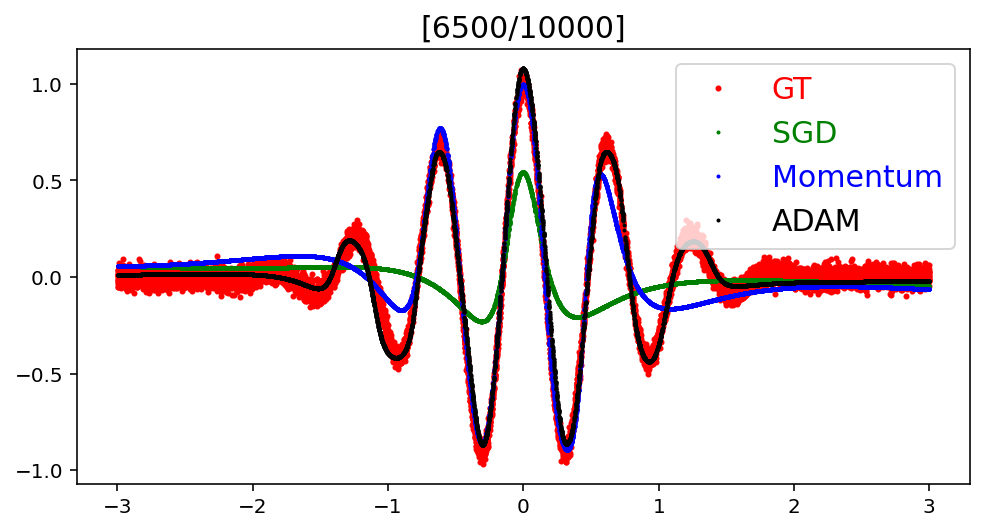

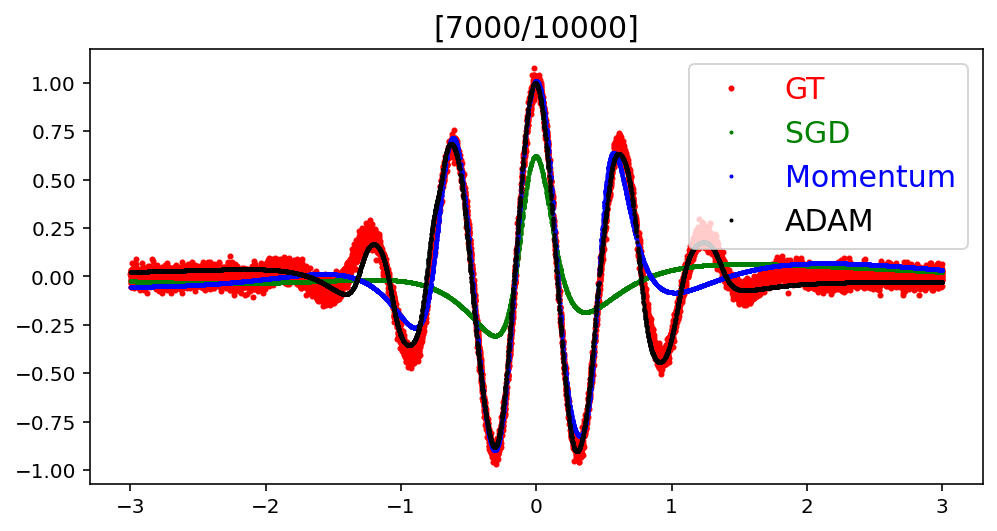

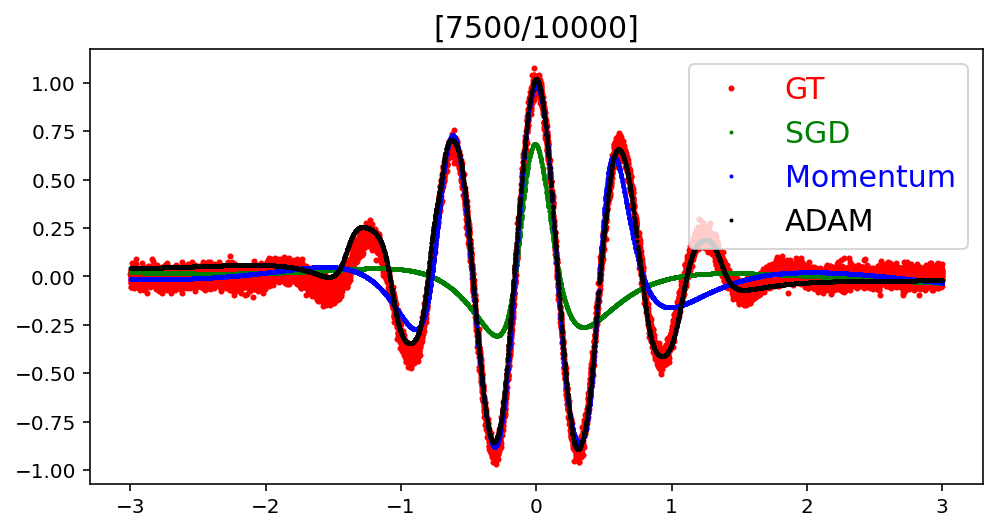

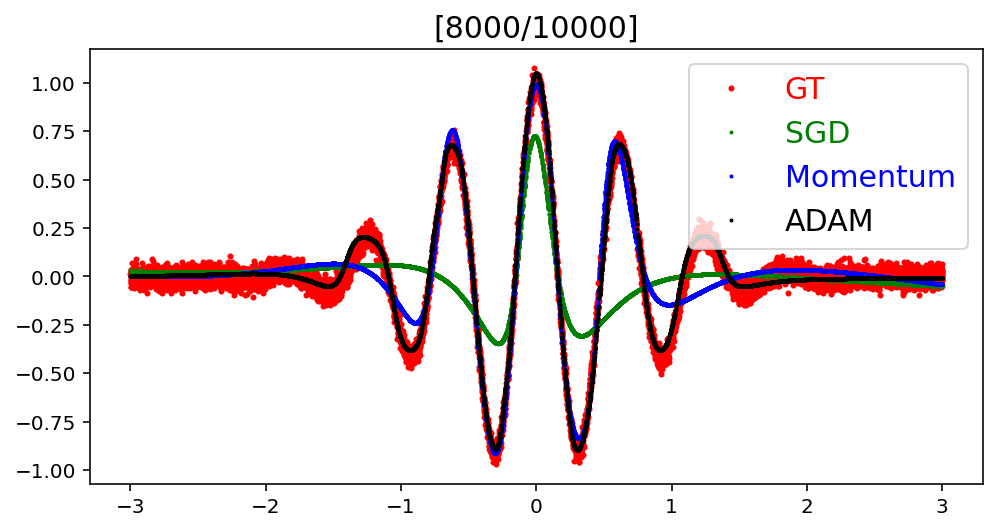

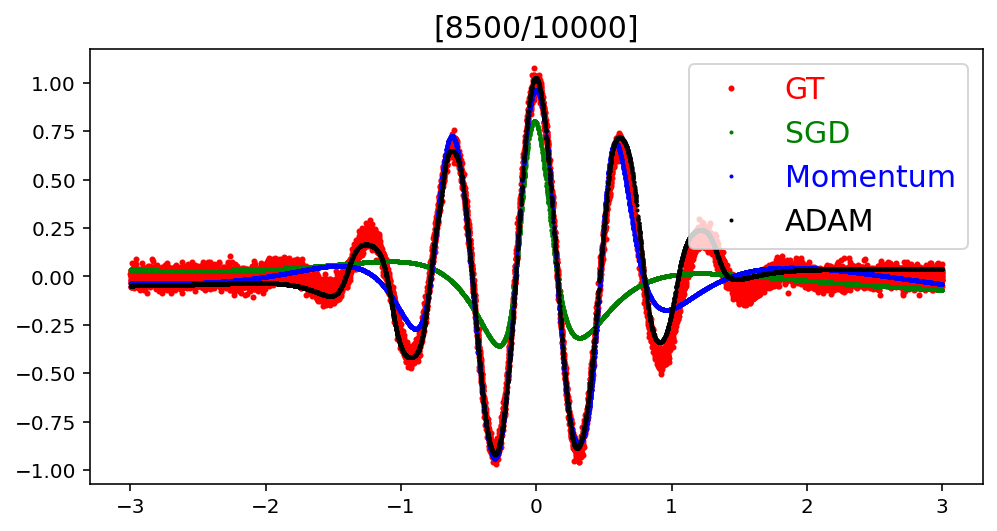

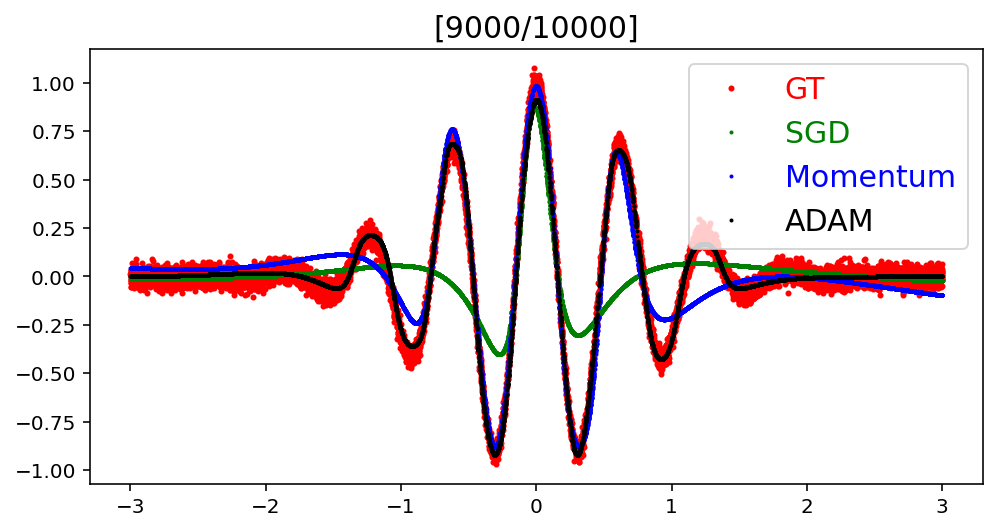

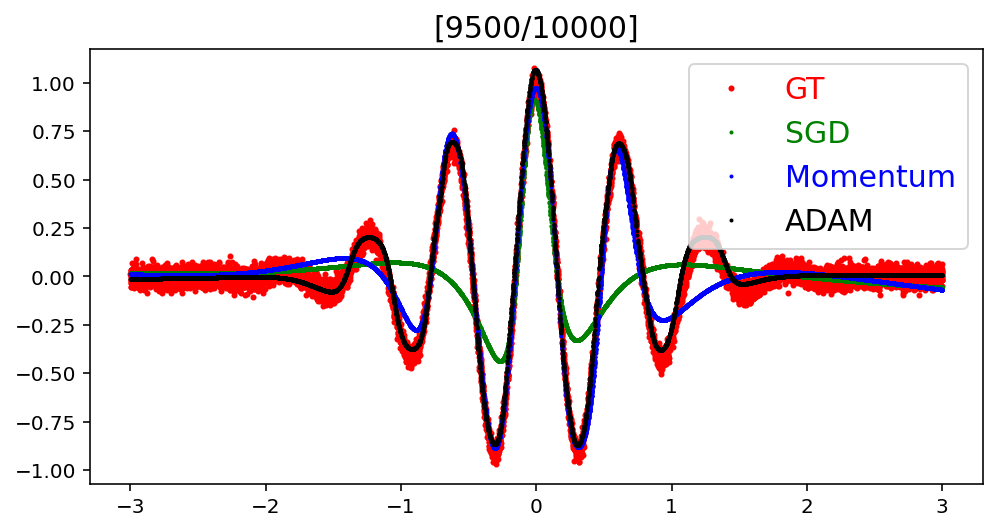

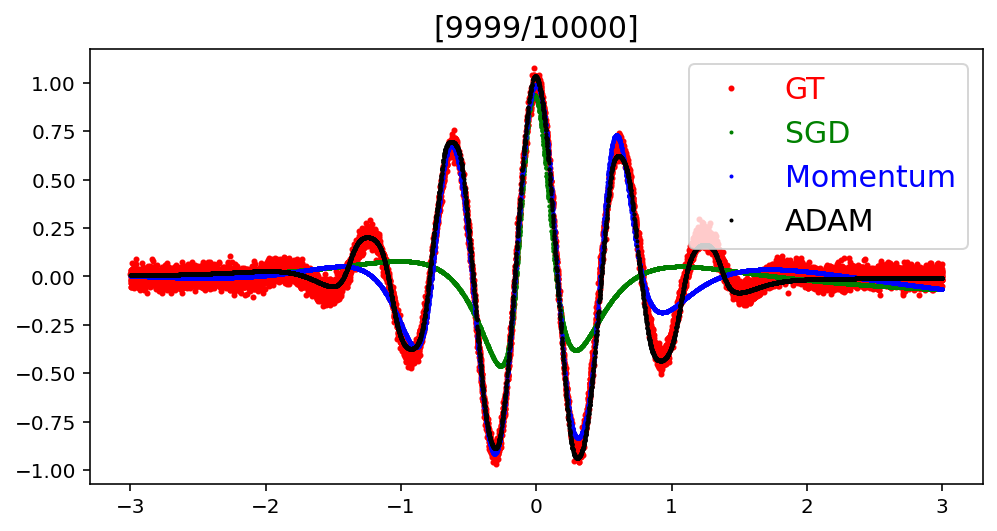

Done.


In [11]:
MAX_ITER,BATCH_SIZE,PLOT_EVERY = 1e4,64,500

model_sgd.init_param()
model_momentum.init_param()
model_adam.init_param()

model_sgd.train()
model_momentum.train()
model_adam.train()

for it in range(int(MAX_ITER)):
    r_idx = np.random.permutation(n_data)[:BATCH_SIZE]
    batch_x,batch_y = x_torch[r_idx],y_torch[r_idx]
    
    # Update with Adam
    y_pred_adam = model_adam.forward(batch_x)
    loss_adam = loss(y_pred_adam,batch_y)
    optm_adam.zero_grad()
    loss_adam.backward()
    optm_adam.step()

    # Update with Momentum
    y_pred_momentum = model_momentum.forward(batch_x)
    loss_momentum = loss(y_pred_momentum,batch_y)
    optm_momentum.zero_grad()
    loss_momentum.backward()
    optm_momentum.step()

    # Update with SGD
    y_pred_sgd = model_sgd.forward(batch_x)
    loss_sgd = loss(y_pred_sgd,batch_y)
    optm_sgd.zero_grad()
    loss_sgd.backward()
    optm_sgd.step()
    

    # Plot
    if ((it%PLOT_EVERY)==0) or (it==0) or (it==(MAX_ITER-1)):
        with torch.no_grad():
            y_sgd_numpy = model_sgd.forward(x_torch).cpu().detach().numpy()
            y_momentum_numpy = model_momentum.forward(x_torch).cpu().detach().numpy()
            y_adam_numpy = model_adam.forward(x_torch).cpu().detach().numpy()
            
            plt.figure(figsize=(8,4))
            plt.plot(x_numpy,y_numpy,'r.',ms=4,label='GT')
            plt.plot(x_numpy,y_sgd_numpy,'g.',ms=2,label='SGD')
            plt.plot(x_numpy,y_momentum_numpy,'b.',ms=2,label='Momentum')
            plt.plot(x_numpy,y_adam_numpy,'k.',ms=2,label='ADAM')
            plt.title("[%d/%d]"%(it,MAX_ITER),fontsize=15)
            plt.legend(labelcolor='linecolor',loc='upper right',fontsize=15)
            plt.show()

print ("Done.")

## 결과 해석

### ADAM이 왜 잘되는가 
Adam은 Momentum과 AdaGrad(Adaptive learning rate)를 합친것. 둘다 사용하는 것이 중요하다


### 0~+-1 구간에서 SGD는 Momentum보다 못맞췄는가
Momentum은 이전의 Grad를 활용하여 현재 Grad에 반영 한다.(Data가 더 많은 효과) Mini batch에서는 Momentum이 더 잘 된다.

### SGD는 왜 제일 큰 Data를 잘 맞추는가
SGD는 큰 loss는 제곱 시키므로 많이 틀릴수록 더 잘맞춘다


**결과** : ADAM은 2~3000에서 일반화가 되었지만, SGD는 간단한 모델을 10000번이나 돌려도 잘 맞지 않는다. ADAM을 가장 먼저 써보는 것을 권장, 하지만 오랜시간 학습을 하면 SGD가 더 잘맞을 수도 있다.